In [1]:
import os

# Set Kaggle API credentials to download the dataset.
# User must get their own API key from Kaggle.
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download
os.environ['KAGGLE_USERNAME'] = "YOURKAGGLEUSERNAME"
os.environ['KAGGLE_KEY'] = "YOURKAGGLEKEY"


In [2]:
# Download and unzip the dataset using shell commands.
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_data
# Check files
import os
os.listdir('brain_tumor_data')


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 77% 115M/149M [00:00<00:00, 1.20GB/s]
100% 149M/149M [00:00<00:00, 1.01GB/s]


['Testing', 'Training']

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create a generator for training data with augmentation.
# ImageDataGenerator is used to generate batches of tensor image data with real-time data augmentation.
train_datagen = ImageDataGenerator(
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,s
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load images for training from the specified directory.
train_generator = train_datagen.flow_from_directory(
    'brain_tumor_data/Training', # Path to the training dataset directory.
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
# Load images for validation from the specified directory.
validation_generator = validation_datagen.flow_from_directory(
    'brain_tumor_data/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:
# Load the base model with pre-trained ImageNet weights, excluding the top classifier
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add our custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Use a strong dropout rate
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# Setup Callbacks for tensorboard
log_dir = "logs/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Monitor the validation loss. 5 epochs with no improvement after which training will be stopped.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model for the first phase of training.
model.compile(
    optimizer=Adam(learning_rate=0.0001), # A low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training The Head
print("Starting Phase 1: Training the Head")
history = model.fit(
    train_generator,
    epochs=10, #EarlyStopping will find the best one
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

--- Starting Phase 1: Training the Head ---
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.3379 - loss: 1.4245

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 556ms/step - accuracy: 0.3381 - loss: 1.4240 - val_accuracy: 0.4439 - val_loss: 1.1724
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 499ms/step - accuracy: 0.4480 - loss: 1.1823 - val_accuracy: 0.4371 - val_loss: 1.2049
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 497ms/step - accuracy: 0.4760 - loss: 1.1268 - val_accuracy: 0.5050 - val_loss: 1.1408
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 503ms/step - accuracy: 0.5189 - loss: 1.0735 - val_accuracy: 0.5195 - val_loss: 1.1063
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 501ms/step - accuracy: 0.5283 - loss: 1.0719 - val_accuracy: 0.5378 - val_loss: 1.1059
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 491ms/step - accuracy: 0.5182 - loss: 1.0653 - val_accuracy: 0.4996 - val_loss: 1.1421
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 499ms/step - accuracy: 0.5373 - loss: 1.0489 - val_accuracy: 0.5095 - val_loss: 1.1313
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 488ms/step - accuracy: 0.5421 - loss: 1.0354 - 

In [23]:
# We want to fine-tune the entire model, including the pre-trained layers.
base_model.trainable = True

# Re-compile for Phase 2 with a smmall learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Very low learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Phase 2
print("Starting Phase 2: Fine-Tuning")
history_fine_tune = model.fit(
    train_generator,
    epochs=history.epoch[-1] + 10, # Continue training for 10 more epochs
    initial_epoch=history.epoch[-1], # Continue where we left off
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

--- Starting Phase 2: Fine-Tuning ---
Epoch 10/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 193s 739ms/step - accuracy: 0.3256 - loss: 16.1851 - val_accuracy: 0.3089 - val_loss: 14.7471
Epoch 11/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 576ms/step - accuracy: 0.7486 - loss: 0.8127 - val_accuracy: 0.3089 - val_loss: 10.2587
Epoch 12/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.8498 - loss: 0.4293 - val_accuracy: 0.3089 - val_loss: 8.4767
Epoch 13/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 573ms/step - accuracy: 0.8925 - loss: 0.3221 - val_accuracy: 0.3089 - val_loss: 7.0746
Epoch 14/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 573ms/step - accuracy: 0.9095 - loss: 0.2417 - val_accuracy: 0.3364 - val_loss: 4.5988
Epoch 15/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 573ms/step - accuracy: 0.9194 - loss: 0.2278 - val_accuracy: 0.5172 - val_loss: 1.5342
Epoch 16/19
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 575ms/step - accuracy: 0.9339 - loss: 0.1728 - val_accuracy: 0.6049 - val_loss: 1.1834
Epoch 17/19
179/179 ━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step


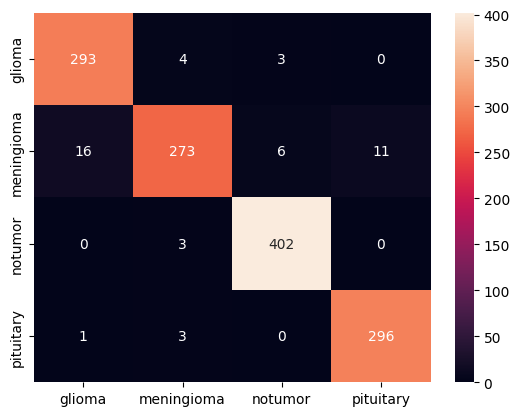

In [26]:
#import essential tools for a more detailed evaluation of classification model performance.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions from the model on the test/validation generator.
Y_pred = model.predict(test_generator)
# Convert probabilities to predicted class labels.
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [27]:
# The classification report shows precision, recall, f1-score, and support for each class.
# Precision: TP / (TP + FP)
# Recall: TP / (TP + FN)
# F1-score: 2 * (Precision * Recall) / (Precision + Recall)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      glioma       0.95      0.98      0.96       300
  meningioma       0.96      0.89      0.93       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [29]:
#import more essential tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get Predictions for the Entire Validation Set
print("Generating predictions for evaluation")
# Reset the generator to ensure it starts from the first batch
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())


--- Generating predictions for evaluation ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step



--- Visualizing Sample Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


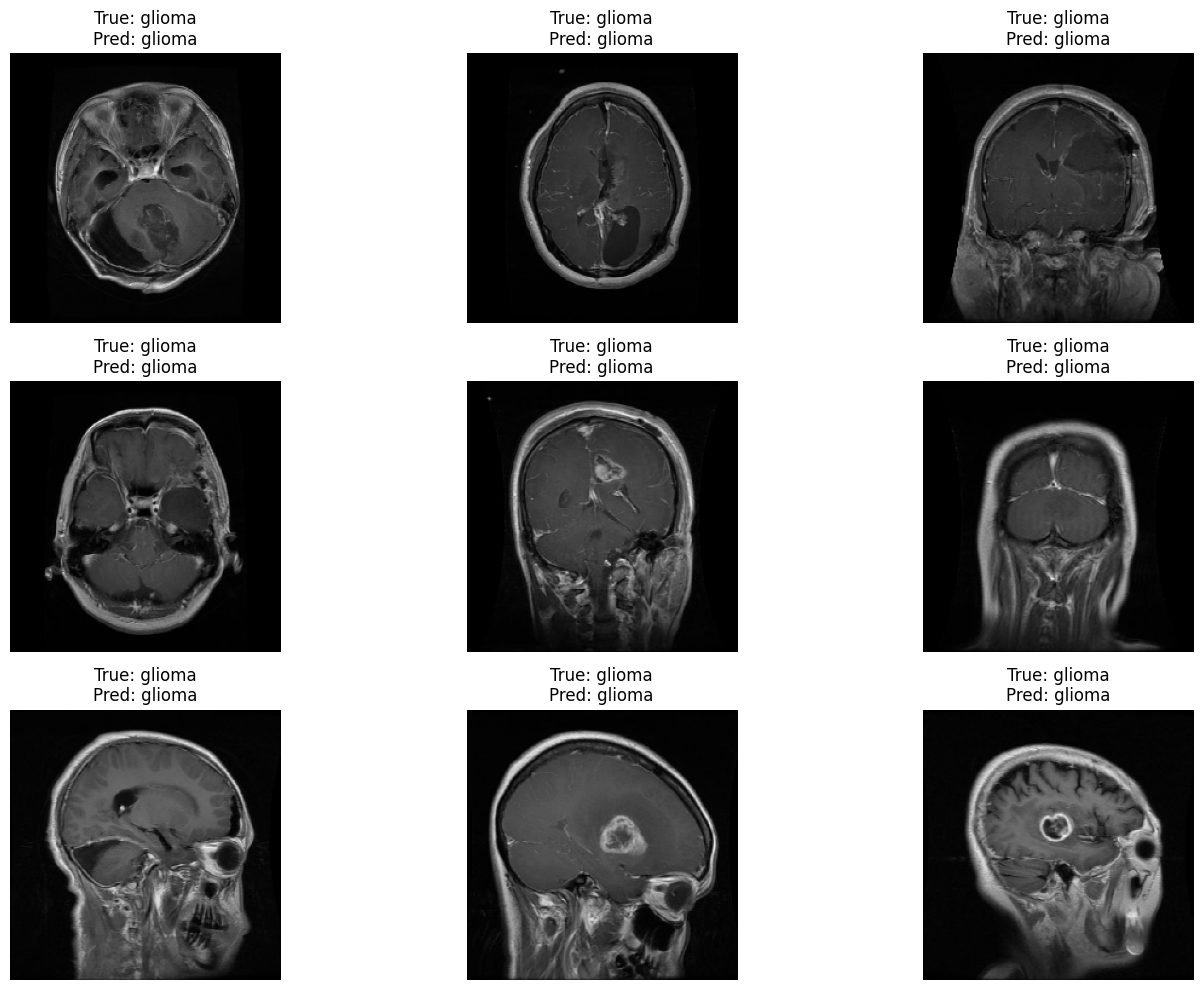

In [32]:

# Visualize Predictions on a Few Sample Images
print("Visualizing Sample Predictions")
# Reset generator again to get the same order
validation_generator.reset()
plt.figure(figsize=(15, 10))
for i in range(9):
    # Get a batch of images
    X_batch, Y_batch = next(validation_generator)
    # Get the first image from the batch
    image = X_batch[0]
    true_label_index = np.argmax(Y_batch[0])

    # Make a prediction
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_label_index = np.argmax(prediction_scores)

    # Plotting
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[true_label_index]}\nPred: {class_names[predicted_label_index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()



--- Visualizing Misclassified Images ---


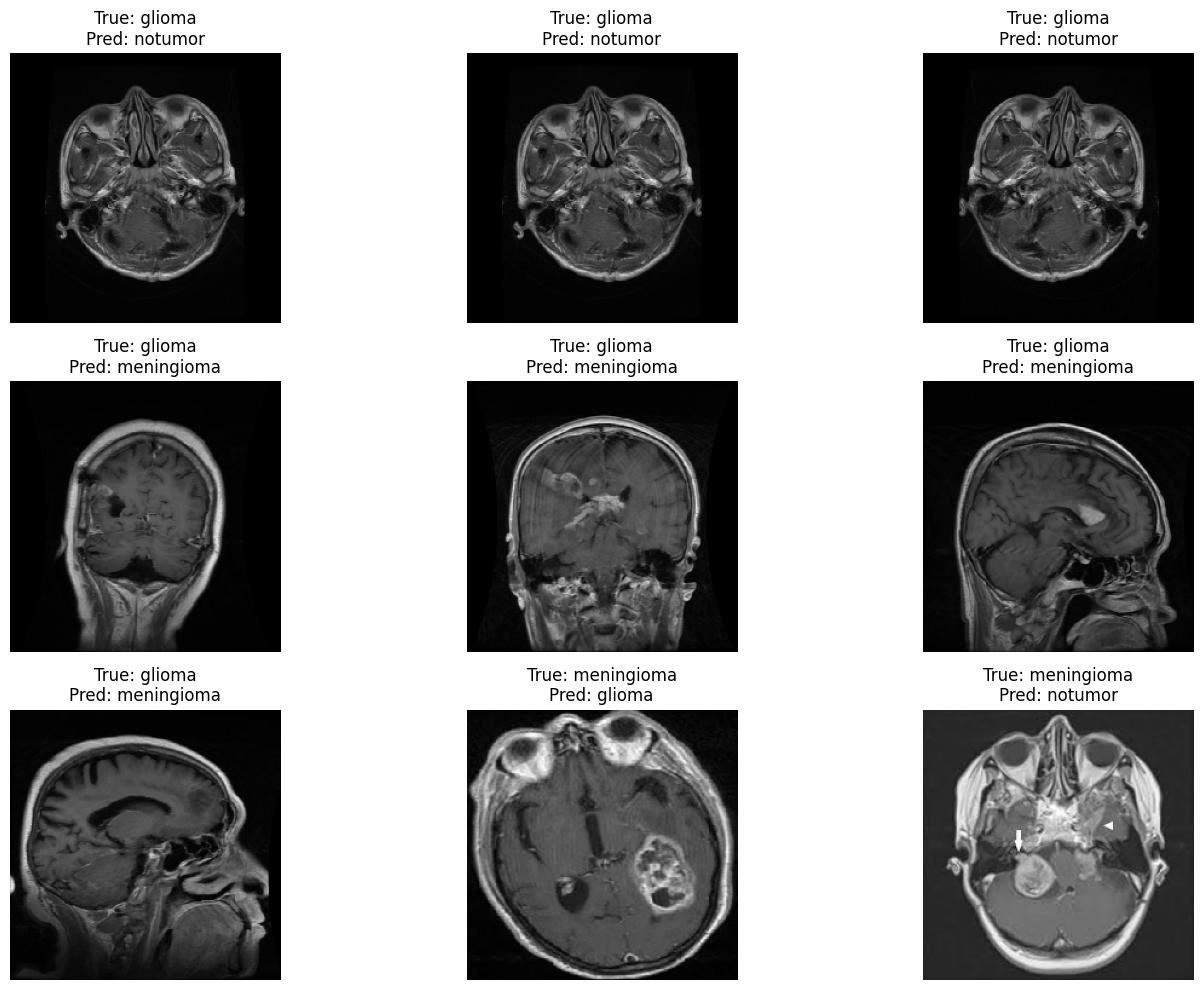

In [33]:

# Identify and Visualize Misclassified Images
print(" Visualizing Misclassified Images ")
misclassified_indices = np.where(y_pred != y_true)[0]
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:9]): # Show the first 9 misclassifications
    #need to regenerate the data
    img_path = validation_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)

    true_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

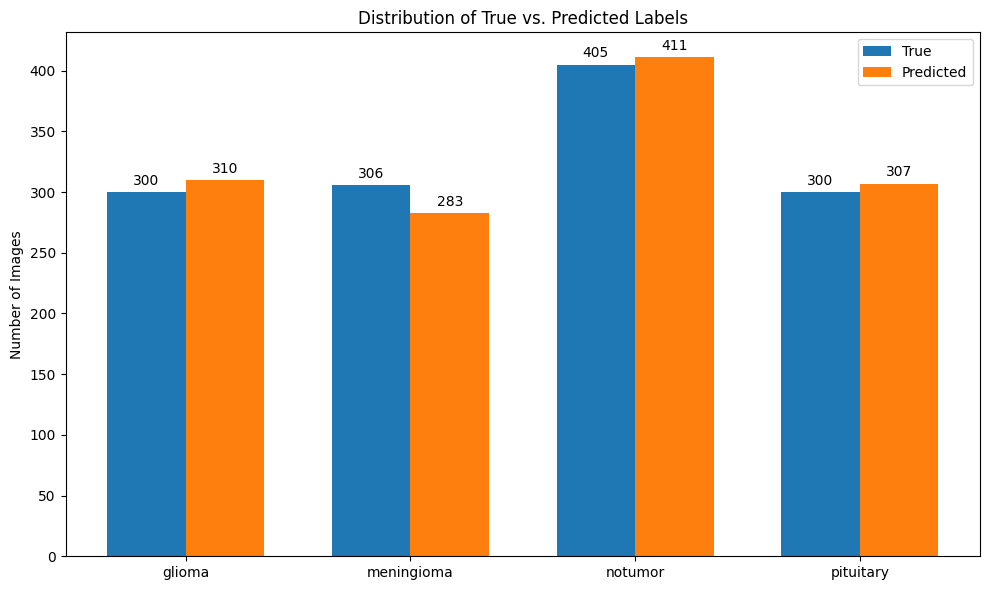

In [37]:
# Count true labels
true_counts = np.bincount(y_true)
# Count predicted labels
pred_counts = np.bincount(y_pred)

plt.figure(figsize=(10, 6))

x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, true_counts, width, label='True')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

# Add some text
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of True vs. Predicted Labels')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

def autolabel(rects):
    #Attach a text label above each bar, displaying its height.
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()
